# 2. Preprocessing

- Normalisation de l'intensité des pixels des images

- travail sur les masques : dilation éventuellement pour inclure les bords des poumons

- application des masques sur les images

- suppression d'artefacts : en a-t-on besoin ?

In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from IPython.display import display, Image

In [2]:
cwd_dir = os.getcwd()
print(cwd_dir)

data_path = os.path.join("..", "data", "processed")
folder_content_list = os.listdir(
    data_path)
print(folder_content_list)

c:\Users\Nicolas\Documents\DataScience\MAR24_BDS_Radios_Pulmonaire\notebooks
['.gitkeep', 'Lung Segmentation Data', 'test NB']


In [3]:
## Chemins d'accès des fichiers

data_path = os.path.join("..", "data", "processed")

average_images_path = os.path.join(data_path, "average_images")

covid_path = os.path.join(data_path, "Lung Segmentation Data", "COVID-19")
noncovid_path = os.path.join(data_path, "Lung Segmentation Data", "Non-COVID")
normal_path = os.path.join(data_path, "Lung Segmentation Data", "Normal")

covid_path_images = os.path.join(covid_path, "images")
noncovid_path_images = os.path.join(noncovid_path, "images")
normal_path_images =os.path.join(normal_path, "images")

covid_path_masks = os.path.join(covid_path, "lung masks")
noncovid_path_masks = os.path.join(noncovid_path, "lung masks")
normal_path_masks =os.path.join(normal_path, "lung masks")

covid_path_images_norm = os.path.join("..", "data", "processed", "test NB", "COVID_norm")
noncovid_path_images_norm = os.path.join("..", "data", "processed", "test NB", "Non-COVID_norm")
normal_path_images_norm =os.path.join("..", "data", "processed", "test NB", "Normal_norm")

covid_path_maskapplied = os.path.join("..", "data", "processed", "test NB", "COVID_norm_appliedmasks")
noncovid_path_maskapplied = os.path.join("..", "data", "processed", "test NB", "Non-COVID_norm_appliedmasks")
normal_path_maskapplied =os.path.join("..", "data", "processed", "test NB", "Normal_norm_appliedmasks")

covid_path_enlargedmasks = os.path.join("..", "data", "processed", "test NB", "COVID_enlargedmasks")
noncovid_path_enlargedmasks = os.path.join("..", "data", "processed", "test NB", "Non-COVID_enlargedmasks")
normal_path_enlargedmasks =os.path.join("..", "data", "processed", "test NB", "Normal_enlargedmasks")

covid_path_norm_appliedenlargedmasks = os.path.join("..", "data", "processed", "test NB", "COVID_norm_appliedenlargedmasks")
noncovid_path_norm_appliedenlargedmasks = os.path.join("..", "data", "processed", "test NB", "Non-COVID_norm_appliedenlargedmasks")
normal_path_norm_appliedenlargedmasks =os.path.join("..", "data", "processed", "test NB", "Normal_norm_appliedenlargedmasks")

## Dictionnaires des chemins d'accès

dict_data_path = {
    'COVID' : covid_path,
    'Non-COVID' : noncovid_path,
    'Normal' : normal_path,
}

dict_images_path = {
    'COVID' : covid_path_images,
    'Non-COVID' : noncovid_path_images,
    'Normal' : normal_path_images,
}

dict_images_norm_path = {
    'COVID' : covid_path_images_norm,
    'Non-COVID' : noncovid_path_images_norm,
    'Normal' : normal_path_images_norm,
} 

dict_masks_path = {
    'COVID' : covid_path_masks,
    'Non-COVID' : noncovid_path_masks,
    'Normal' : normal_path_masks,
} 

dict_masksapplied_path = {
    'COVID' : covid_path_maskapplied,
    'Non-COVID' : noncovid_path_maskapplied,
    'Normal' : normal_path_maskapplied,
}

dict_enlargedmasks_path = {
    'COVID' : covid_path_enlargedmasks,
    'Non-COVID' : noncovid_path_enlargedmasks,
    'Normal' : normal_path_enlargedmasks,
}

dict_appliedenlargedmasks_path = {
    'COVID' : covid_path_norm_appliedenlargedmasks,
    'Non-COVID' : noncovid_path_norm_appliedenlargedmasks,
    'Normal' : normal_path_norm_appliedenlargedmasks,
}

## Normalisation de l'intensité des pixels des images

J'ai choisi de normaliser les données en utilisant une fonction d'histogramme égalisé. En effet, il s'agit d'une méthode qui redistribue l'intensité des pixels dans une image de façon à améliorer le contraste des images et rendre les structures pertinentes plus visibles. Chaque image sera normalisé indépendamment de sa catégorie (COVID, non COVID et Normal).

In [7]:
#------------------------------------------------------------#

## Fonction pour normaliser les images d'un dossier que l'on spécifie

def normalisation(input_dict, output_dict, normalisation="histogramme"):
    """
    Normalise les images contenues dans plusieurs dossiers en utilisant différentes méthodes de normalisation.

    Args:
        input_dict (dict): Dictionnaire contenant les chemins des dossiers d'entrée comme clés.
        output_dict (dict): Dictionnaire contenant les chemins des dossiers de sortie correspondants comme valeurs.
        normalisation (str): Méthode de normalisation à utiliser. Les valeurs possibles sont "histogramme" (par défaut),
                             "zscore", "minmax", "adaptative", "pourcentage" ou "autre".

    """
    # Vérifier si les dictionnaires d'entrée et de sortie ont le même nombre d'éléments
    if len(input_dict) != len(output_dict):
        print("Le nombre de dictionnaires d'entrée ne correspond pas au nombre de dictionnaires de sortie.")
        return

    # Boucle sur les entrées du dictionnaire d'entrée
    for input_key, input_folder in input_dict.items():
        # Vérifier si le dossier de sortie correspondant existe
        output_folder = output_dict.get(input_key)
        if output_folder is None:
            print(f"Aucun dossier de sortie correspondant trouvé pour {input_key}.")
            continue

        # Liste des fichiers dans le dossier d'entrée
        fichiers = os.listdir(input_folder)

        # Boucle sur les fichiers dans le dossier d'entrée
        for fichier in fichiers:
            # Chemin complet de l'image d'entrée
            chemin_entree = os.path.join(input_folder, fichier)
            
            # Lire l'image
            image = cv2.imread(chemin_entree)

            # Vérifier si l'image a été correctement lue
            if image is not None:
                # Convertir l'image en niveaux de gris
                image_gris = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                
                # Appliquer la méthode de normalisation spécifiée
                if normalisation == "histogramme":
                    # Appliquer l'histogramme égalisé
                    image_normalisee = cv2.equalizeHist(image_gris)
                elif normalisation == "zscore":
                    # Normaliser les intensités des pixels entre moyenne 0 et écart-type 1 (Z-score)
                    image_normalisee = cv2.normalize(image_gris, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
                elif normalisation == "minmax":
                    # Normaliser les intensités des pixels entre 0 et 1 (min-max)
                    image_normalisee = cv2.normalize(image_gris, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
                elif normalisation == "adaptative":
                    # Normalisation adaptative locale
                    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
                    image_normalisee = clahe.apply(image_gris)
                elif normalisation == "pourcentage":
                    # Normalisation par pourcentage linéaire
                    min_val = np.percentile(image_gris, 5)
                    max_val = np.percentile(image_gris, 95)
                    image_normalisee = cv2.normalize(image_gris, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
                else:
                    print("Méthode de normalisation non valide. Utilisez l'une des valeurs suivantes : 'histogramme', 'zscore', 'minmax', 'adaptative', 'pourcentage'")
                    return

                # Chemin complet de l'image de sortie
                chemin_sortie = os.path.join(output_folder, fichier)

                # Enregistrer l'image normalisée dans le dossier de sortie
                cv2.imwrite(chemin_sortie, image_normalisee)
            else:
                print(f"Impossible de charger l'image {fichier} dans le dossier {input_folder}.")

#-----------------------------------------------------------------------#

### Affichage d'images de radios normalisées sélectionnées au hasard

In [4]:
def afficher_images_aleatoires(dossier, nombre_images):
    """
    Affiche un nombre donné d'images sélectionnées aléatoirement à partir d'un dossier.
    
    Args:
    - dossier (str): Chemin du dossier contenant les images.
    - nombre_images (int): Nombre d'images à afficher.
    """
    # Vérifier si le dossier existe
    if not os.path.exists(dossier):
        print("Le dossier spécifié n'existe pas.")
        return
    
    # Liste des fichiers dans le dossier
    fichiers = os.listdir(dossier)
    
    # Filtrer les fichiers pour ne garder que les images
    images = [fichier for fichier in fichiers if fichier.endswith(('.png', '.jpg', '.jpeg', '.gif'))]
    
    # Vérifier s'il y a suffisamment d'images dans le dossier
    if len(images) < nombre_images:
        print("Le dossier ne contient pas suffisamment d'images.")
        return
    
    # Sélectionner aléatoirement les images
    images_aleatoires = random.sample(images, nombre_images)
    
    # Afficher les images dans le notebook
    for image in images_aleatoires:
        chemin_image = os.path.join(dossier, image)
        display(Image(filename=chemin_image))

# Exemple d'utilisation :
dossier_images = "chemin/vers/votre/dossier"
nombre_images_a_afficher = 5
afficher_images_aleatoires(dossier_images, nombre_images_a_afficher)

Le dossier spécifié n'existe pas.


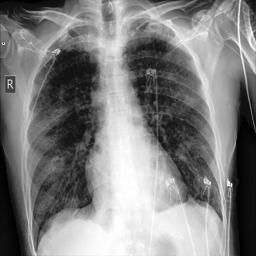

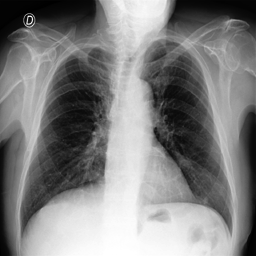

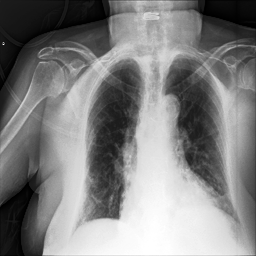

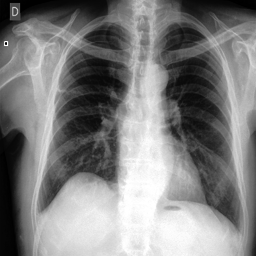

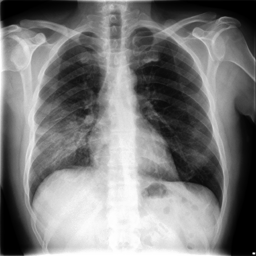

In [7]:
afficher_images_aleatoires (covid_path_images_norm, 5)

### Calcul de l'intensité moyenne de pixels après normalisation

Une simple vérification.

In [8]:
#-----------------------------------------------------------------------#

def calculer_intensite_moyenne_dossier(dossier_images, categorie):
    """
    Calcule l'intensité moyenne des images contenues dans un dossier.

    Args:
        dossier_images (str): Chemin du dossier contenant les images.

    Returns:
        float: Intensité moyenne des images du dossier.
    """
    # Vérifier si le dossier existe
    if not os.path.isdir(dossier_images):
        print("Le chemin spécifié n'est pas un dossier valide.")
        return None

    intensites = []

    # Parcourir tous les fichiers du dossier
    for nom_fichier in os.listdir(dossier_images):
        # Chemin complet du fichier
        chemin_fichier = os.path.join(dossier_images, nom_fichier)

        # Vérifier si le fichier est un fichier image
        if os.path.isfile(chemin_fichier) and nom_fichier.lower().endswith(('.png', '.jpg', '.jpeg')):
            # Charger l'image
            image = cv2.imread(chemin_fichier)

            # Vérifier si l'image est chargée avec succès
            if image is not None:
                # Convertir l'image en niveaux de gris
                gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

                # Calculer l'intensité moyenne de l'image
                mean_intensity = cv2.mean(gray_image)[0]

                # Ajouter l'intensité moyenne à la liste
                intensites.append(mean_intensity)
            else:
                print(f"Impossible de charger l'image {nom_fichier}")

    if intensites:
    # Tracer les histogrammes
        plt.hist(intensites, bins=20, alpha=0.5, density=True)
        plt.xlabel('Intensité moyenne')
        plt.ylabel('Fréquence')
        plt.title(f'Histogramme des intensités moyennes des images {categorie} normalisées')
        plt.show();
    else:
        print("Aucune image valide trouvée dans le dossier.")
        return None

#-----------------------------------------------------------------------#

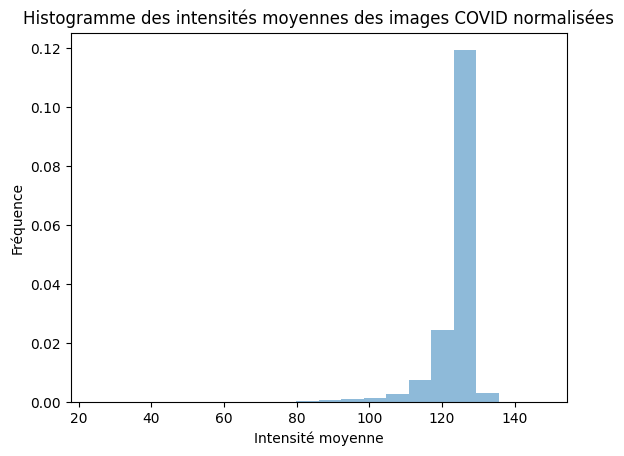

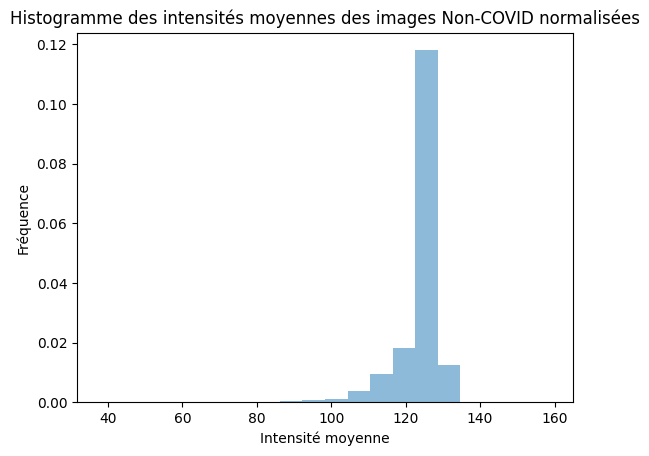

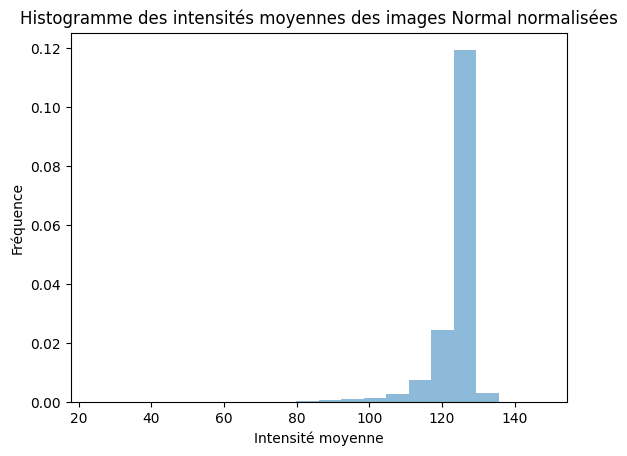

In [30]:
#-----------------------------------------------------------------------#

## Test de la fonction de calcul de l'intensité moyenne de pixels

calculer_intensite_moyenne_dossier(covid_path_images_norm, 'COVID')
calculer_intensite_moyenne_dossier(noncovid_path_images_norm, 'Non-COVID')
calculer_intensite_moyenne_dossier(covid_path_images_norm, 'Normal')
#-----------------------------------------------------------------------#

On constate que les intensités ont été normalisées autour de 120 en moyenne.

In [9]:
#-----------------------------------------------------------------------#

## Fonction pour appliquer les masques sur les images normalisées

def appliquer_masques(input_images_dict, input_masks_dict, output_folders_dict, method="bitwise_and"):
    """
    Applique les masques sur les images d'entrée et enregistre les images masquées dans les dossiers de sortie.

    Args:
        input_images_dict (dict): Dictionnaire contenant les chemins des dossiers d'images en entrée.
        input_masks_dict (dict): Dictionnaire contenant les chemins des dossiers de masques correspondants.
        output_folders_dict (dict): Dictionnaire contenant les chemins des dossiers de sortie correspondants où enregistrer les images masquées.
        method (str): Méthode d'application de masque à utiliser. Les valeurs possibles sont "bitwise_and" (par défaut) et "copyTo".
    """
    # Vérifier si les dictionnaires ont le même nombre d'éléments
    if len(input_images_dict) != len(input_masks_dict) != len(output_folders_dict):
        print("Le nombre de dictionnaires d'images, de masques et de sortie ne correspond pas.")
        return

    # Vérifier si la méthode spécifiée est valide
    if method not in ["bitwise_and", "copyTo"]:
        print("Méthode d'application de masque non valide. Utilisez 'bitwise_and' ou 'copyTo'.")
        return

    # Boucle sur les entrées des dictionnaires
    for input_key, input_images_folder in input_images_dict.items():
        # Vérifier si le dossier d'images existe
        if not os.path.exists(input_images_folder):
            print(f"Le dossier d'images {input_images_folder} n'existe pas.")
            continue
        
        # Vérifier si le dossier de masques correspondant existe
        input_masks_folder = input_masks_dict.get(input_key)
        if input_masks_folder is None or not os.path.exists(input_masks_folder):
            print(f"Aucun dossier de masques correspondant trouvé pour {input_key}.")
            continue
        
        # Vérifier si le dossier de sortie correspondant existe
        output_folder = output_folders_dict.get(input_key)
        if output_folder is None:
            print(f"Aucun dossier de sortie correspondant trouvé pour {input_key}.")
            continue

        # Liste des fichiers dans le dossier d'images
        files = os.listdir(input_images_folder)

        # Boucle sur les fichiers dans le dossier d'images
        for file in files:
            # Chemin complet de l'image d'entrée
            input_image_path = os.path.join(input_images_folder, file)

            # Lire l'image
            image = cv2.imread(input_image_path)

            # Vérifier si l'image a été correctement lue
            if image is not None:
                # Chemin complet du masque correspondant
                input_mask_path = os.path.join(input_masks_folder, file)

                # Lire le masque
                mask = cv2.imread(input_mask_path, cv2.IMREAD_GRAYSCALE)

                # Vérifier si le masque a été correctement lu
                if mask is not None:
                    # Appliquer le masque sur l'image en fonction de la méthode spécifiée
                    if method == "bitwise_and":
                        masked_image = cv2.bitwise_and(image, image, mask=mask)
                    elif method == "copyTo":
                        masked_image = cv2.copyTo(image, mask)
                    
                    # Chemin complet de l'image de sortie
                    output_image_path = os.path.join(output_folder, file)

                    # Enregistrer l'image masquée dans le dossier de sortie
                    cv2.imwrite(output_image_path, masked_image)
                else:
                    print(f"Impossible de charger le masque {input_mask_path} pour l'image {file}.")
            else:
                print(f"Impossible de charger l'image {input_image_path}.")

#-----------------------------------------------------------------------#

In [19]:
#-----------------------------------------------------------------------#

## Test de la fonction d'application des masques

appliquer_masques(dict_images_norm_path, dict_enlargedmasks_path, dict_appliedenlargedmasks_path, method="bitwise_and")

#-----------------------------------------------------------------------#


### Affichage d'images au hasard avec les masques appliqués

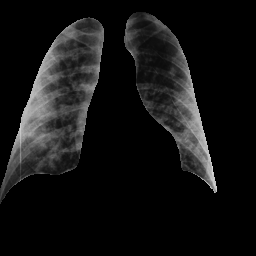

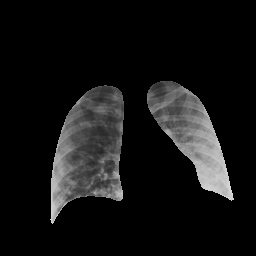

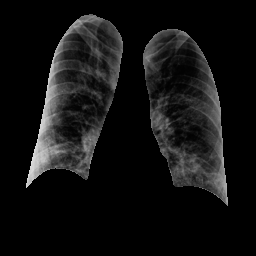

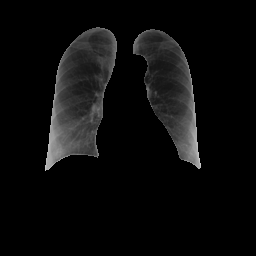

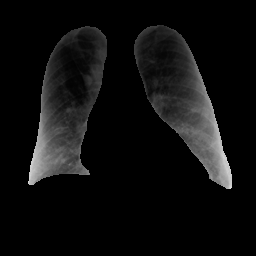

In [8]:
afficher_images_aleatoires (covid_path_maskapplied, 5)

In [15]:
#-----------------------------------------------------------------------#

## Fonction pour élargir les masques => informations importantes sur les bords des poumons

def agrandir_masque(input_folders, output_folders, iterations, kernel_size):
    """
    Agrandit un masque en utilisant l'opération de dilatation.

    Args:
        input_folders (dict): Dictionnaire de dossiers d'entrée avec les chemins vers les masques.
        output_folders (dict): Dictionnaire de dossiers de sortie pour enregistrer les masques agrandis.
        iterations (int): Nombre d'itérations de l'opération de dilatation.
        kernel_size (int): Taille du noyau de dilatation.

    Returns:
        None
    """
    # Définition du noyau de dilatation
    kernel = np.ones((kernel_size, kernel_size), np.uint8)

    # Parcourir chaque dossier d'entrée
    for label, input_folder in input_folders.items():
        output_folder = output_folders[label]

        # Vérifier si le dossier de sortie existe, sinon le créer
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)

        # Parcourir les fichiers dans le dossier d'entrée
        for file_name in os.listdir(input_folder):
            # Lire le masque
            mask_path = os.path.join(input_folder, file_name)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            # Appliquer l'opération de dilatation
            dilated_mask = cv2.dilate(mask, kernel, iterations=iterations)

            # Enregistrer le masque agrandi dans le dossier de sortie
            output_path = os.path.join(output_folder, file_name)
            cv2.imwrite(output_path, dilated_mask)


#-----------------------------------------------------------------------#


In [17]:
#-----------------------------------------------------------------------#

## Test de la fonction agrandir les masques

agrandir_masque(dict_masks_path, dict_enlargedmasks_path, kernel_size=5, iterations=2)

#-----------------------------------------------------------------------#

## Comparaison des masques dilatés vs les masques normaux

Je sélectionne au hasard 20 images et je les affiche pour comparer les différences.

In [29]:
def afficher_images_cote_a_cote(dossier1, dossier2):
    """
    Affiche côte à côte 20 images sélectionnées au hasard dans deux dossiers différents.
    Les images sélectionnées dans le deuxième dossier ont les mêmes noms que celles sélectionnées dans le premier dossier.
    
    Args:
        dossier1 (str): Chemin vers le premier dossier contenant les images.
        dossier2 (str): Chemin vers le deuxième dossier contenant les images.

    Returns:
        None
    """
    # Obtenir la liste des noms de fichiers dans le premier dossier
    images_dossier1 = os.listdir(dossier1)

    # Sélectionner au hasard 20 images dans le premier dossier
    images_aleatoires_dossier1 = random.sample(images_dossier1, 20)

    # Créer une fenêtre pour afficher les images
    cv2.namedWindow('Images côte à côte', cv2.WINDOW_NORMAL)

    # Créer une liste pour stocker les images à afficher
    images_a_afficher = []

    # Charger les images du premier dossier et les ajouter à la liste
    for nom_fichier in images_aleatoires_dossier1:
        img_path_dossier1 = os.path.join(dossier1, nom_fichier)
        img_path_dossier2 = os.path.join(dossier2, nom_fichier)

        if os.path.exists(img_path_dossier2):
            img_dossier1 = cv2.imread(img_path_dossier1)
            img_dossier2 = cv2.imread(img_path_dossier2)

            images_a_afficher.append(img_dossier1)
            images_a_afficher.append(img_dossier2)

    # Afficher les images côte à côte
    rows = 10
    cols = 2
    for i in range(0, len(images_a_afficher), cols):
        row_images = images_a_afficher[i:i+cols]
        combined_image = cv2.hconcat(row_images)
        cv2.imshow('Images côte à côte', combined_image)
        cv2.waitKey(0)

    # Fermer la fenêtre lorsqu'une touche est pressée
    cv2.destroyAllWindows()

In [30]:
afficher_images_cote_a_cote(covid_path_maskapplied, covid_path_norm_appliedenlargedmasks)

In [31]:
def sauvegarder_images_cote_a_cote(dossier1, dossier2, output_path):
    """
    Combine 20 images sélectionnées au hasard dans deux dossiers différents et enregistre l'image combinée dans un fichier.

    Args:
        dossier1 (str): Chemin vers le premier dossier contenant les images.
        dossier2 (str): Chemin vers le deuxième dossier contenant les images.
        output_path (str): Chemin de sortie pour enregistrer l'image combinée.

    Returns:
        None
    """
    # Obtenir la liste des noms de fichiers dans le premier dossier
    images_dossier1 = os.listdir(dossier1)

    # Sélectionner au hasard 20 images dans le premier dossier
    images_aleatoires_dossier1 = random.sample(images_dossier1, 20)

    # Créer une liste pour stocker les images à combiner
    images_a_combiner = []

    # Charger les images du premier dossier et les ajouter à la liste
    for nom_fichier in images_aleatoires_dossier1:
        img_path_dossier1 = os.path.join(dossier1, nom_fichier)
        img_path_dossier2 = os.path.join(dossier2, nom_fichier)

        if os.path.exists(img_path_dossier2):
            img_dossier1 = cv2.imread(img_path_dossier1)
            img_dossier2 = cv2.imread(img_path_dossier2)

            images_a_combiner.append(img_dossier1)
            images_a_combiner.append(img_dossier2)

    # Concaténer les images horizontalement
    rows = 10
    cols = 2
    combined_image = None
    for i in range(0, len(images_a_combiner), cols):
        row_images = images_a_combiner[i:i+cols]
        row_combined = cv2.hconcat(row_images)
        if combined_image is None:
            combined_image = row_combined
        else:
            combined_image = cv2.vconcat([combined_image, row_combined])

    # Enregistrer l'image combinée dans un fichier
    cv2.imwrite(output_path, combined_image)
    print(f"L'image combinée a été enregistrée sous: {output_path}")

In [ ]:
sauvegarder_images_cote_a_cote(covid_path_maskapplied, covid_path_norm_appliedenlargedmasks, os.path.join("..", "data", "processed", "test NB"))

### Affichage d'images de masques appliqués et dilatés au hasard

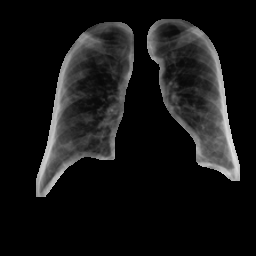

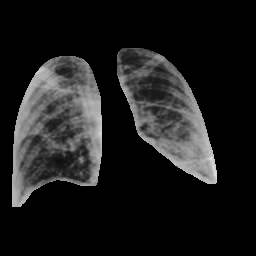

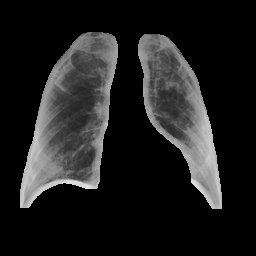

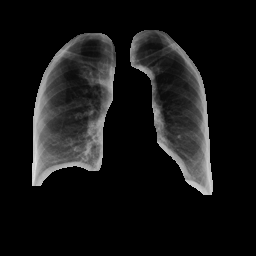

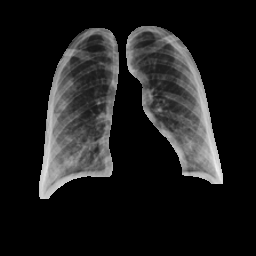

In [9]:
afficher_images_aleatoires (covid_path_norm_appliedenlargedmasks, 5)